### 1. Datasets

In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

p = lambda x,type : f'../../data/{type}/{x}'

22/09/18 10:40:57 WARN Utils: Your hostname, Shromanns-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.3 instead (on interface en0)
22/09/18 10:40:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/18 10:40:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
sdf = spark.read.parquet(p('process_data.parquet', 'curated'), header=True)
df = sdf.where(F.col('merchant_fraud_probability').isNotNull()).select('merchant_name', 'category', 'merchant_fraud_probability')\
    .withColumn('merchant_fraud_probability', F.col('merchant_fraud_probability')/100)\
    .toPandas()
df

,merchant_name,category,merchant_fraud_probability
0,Phasellus At Limited,retail_and_wholesale_trade,0.295397
1,Dolor Quisque Inc.,retail_and_wholesale_trade,0.313435
2,Dolor Quisque Inc.,retail_and_wholesale_trade,0.313435
3,Nec Tellus Ltd,others,0.289569
4,Dignissim Maecenas Foundation,retail_and_wholesale_trade,0.283605
...,...,...,...
3998,Neque Sed Dictum Incorporated,retail_and_wholesale_trade,0.300243
3999,Mauris Non Institute,info_media_and_telecommunications,0.285045
4000,Dignissim Maecenas Foundation,retail_and_wholesale_trade,0.283605
4001,Mauris Non Institute,info_media_and_telecommunications,0.285045


### 2. Visualisations

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

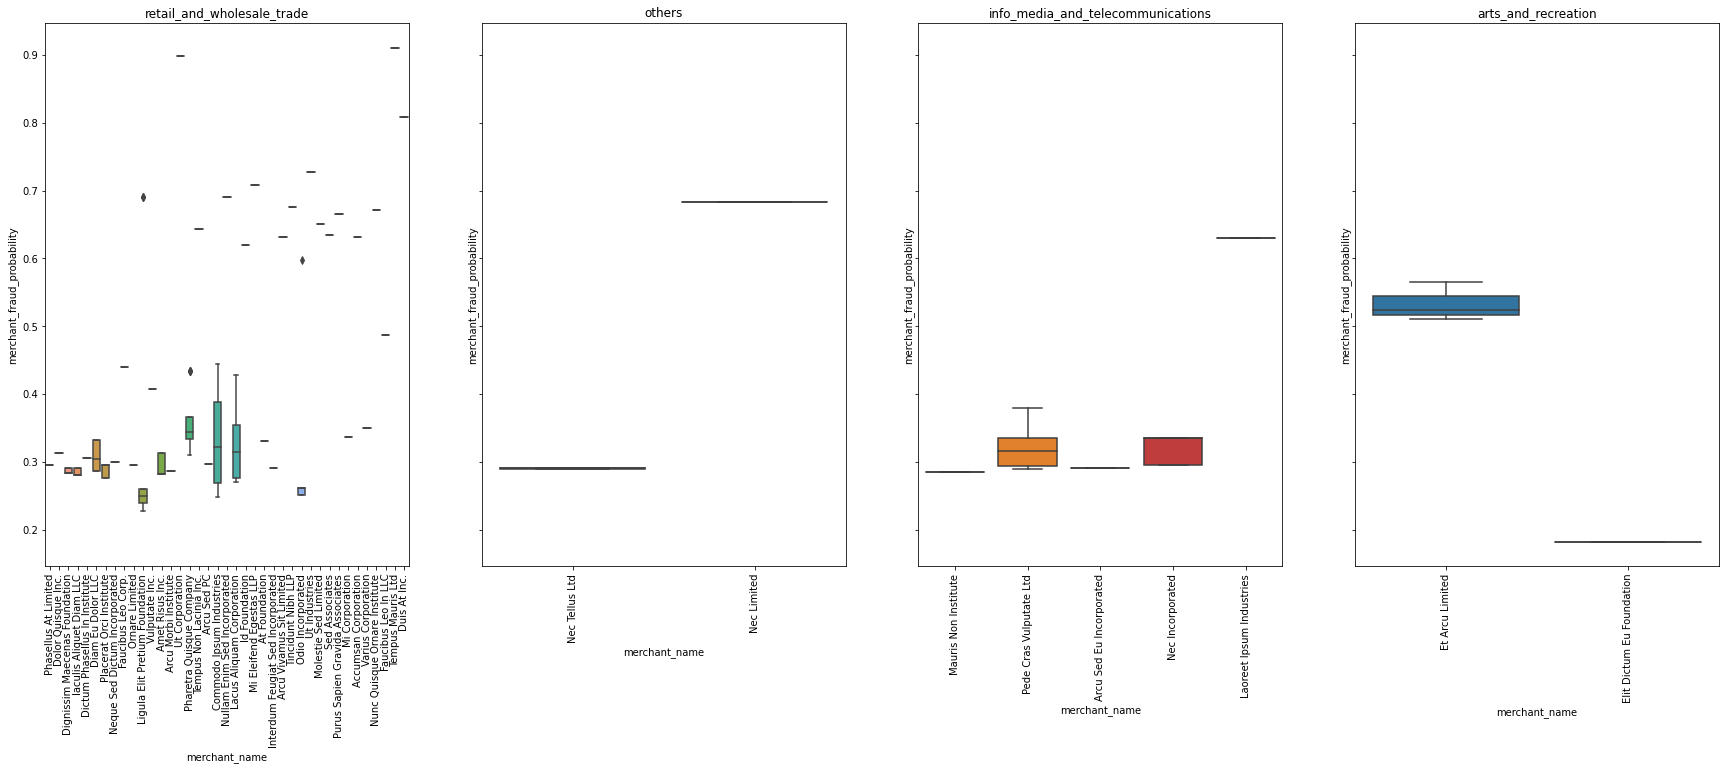

In [4]:
categories = df['category'].unique()
group = df.groupby('category')

fig, axs = plt.subplots(figsize = (30, 10) ,ncols=4, sharey='row')

for i, category in enumerate(categories):
    data = group.get_group(category)
    sns.boxplot(data=data, x='merchant_name', y='merchant_fraud_probability', ax = axs[i], showfliers = True).set_title(category)
    axs[i].tick_params(axis='x', rotation=90)


### 3. Analytics

In [5]:
import pandas as pd

Given the assumption that the type of fraud is repeatable, we can say that date and time of the order is independent of the act of fraud. 

In [6]:
df = pd.read_csv(p('merchant_fraud_probability.csv', 'tables'))
df = df.drop('order_datetime', axis=1)
df['fraud_probability'] = df['fraud_probability'] / 100

df

,merchant_abn,fraud_probability
0,19492220327,0.444037
1,31334588839,0.427553
2,19492220327,0.388678
3,82999039227,0.941347
4,90918180829,0.433255
...,...,...
109,80089686333,0.675058
110,83220249221,0.635125
111,85482742429,0.708813
112,11470993597,0.633773


As shown below, the standard deviation in probability of fraud is dense between 0 to 0.075, with mode around 0.025 and some around 0.20 std.

array([[<AxesSubplot:title={'center':'fraud_probability'}>]], dtype=object)

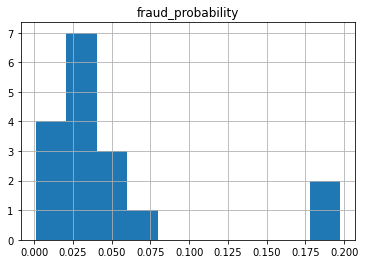

In [7]:
df.groupby('merchant_abn').std().hist()

Goal: Our main goal is to pick out a specific and similar number of merchants from each category.

---

In [12]:
transactions = spark\
    .read.parquet(p('transactions_20220228_20220828_snapshot', 'tables'), header=True)\
    .union(spark.read.parquet(p('transactions_20210828_20220227_snapshot', 'tables'), header=True))\
    .union(spark.read.parquet(p('transactions_20210228_20210827_snapshot', 'tables'), header=True))\
    .dropDuplicates(['order_id'])

M = transactions\
    .join(spark.read.csv(p('merchant_fraud_probability.csv', 'tables'), header=True).withColumn('fraud_probability', F.col('fraud_probability')/100),
     ['merchant_abn', 'order_datetime'])\
    .withColumnRenamed('fraud_probability', 'merchant_fraud_probability')
    
C = transactions\
    .join(spark.read.csv(p('consumer_fraud_probability.csv', 'tables'), header=True).withColumn('fraud_probability', F.col('fraud_probability')/100),
     ['user_id', 'order_datetime'])\
    .withColumnRenamed('fraud_probability', 'consumer_fraud_probability')

MC = transactions\
    .join(spark.read.csv(p('consumer_fraud_probability.csv', 'tables'), header=True).withColumn('fraud_probability', F.col('fraud_probability')/100),
     ['user_id', 'order_datetime'])\
    .withColumnRenamed('fraud_probability', 'consumer_fraud_probability')\
    .join(spark.read.csv(p('merchant_fraud_probability.csv', 'tables'), header=True).withColumn('fraud_probability', F.col('fraud_probability')/100),
     ['merchant_abn', 'order_datetime'])\
    .withColumnRenamed('fraud_probability', 'merchant_fraud_probability')

In [54]:
MC

merchant_abn,order_datetime,user_id,dollar_value,order_id,consumer_fraud_probability,merchant_fraud_probability
90568944804,2021-11-28,22796,810.1539989234536,e2658be2-52b4-4e3...,0.1667051668781912,0.30413429232277567
14827550074,2021-12-11,22919,8410.000882441977,5a723096-46b8-423...,0.23767923725298012,0.39406448021200347
90568944804,2021-11-29,15633,4691.359952452361,6b71c12a-904f-4b8...,0.15676742950240086,0.33172494688960436
90568944804,2021-11-29,18236,154.0036691633034,d8edfea7-31f0-487...,0.13492201335466739,0.33172494688960436
76767266140,2021-11-26,15933,305.7890015256559,8b4b7196-c90d-4d4...,0.14778849148911477,0.29539733207182706
31334588839,2021-12-11,3537,30524.05185796727,cca6c48c-712f-42d...,0.6798462170143736,0.3141575910583001
31334588839,2021-11-29,12357,3558.3782437109967,a9214ea0-94e1-4ec...,0.1133172500634842,0.3538621329737551
79827781481,2021-11-27,13195,3162.2878047380123,fa444120-d1b6-444...,0.17742897634233562,0.2814477428645862
94311056026,2021-12-16,8452,32003.31699230111,b00474d4-41e9-4b7...,0.741089427651979,0.3085150199484772
94311056026,2021-12-16,8452,32003.31699230111,b00474d4-41e9-4b7...,0.741089427651979,0.3085150199484772


We begin with the **probability** that merchant/consumer is given which merchant/consumer and `order_datetime`. We can identify some of the specific fraudulent transactions by checking both probabilities for each transaction. Here `MC` is a dataset that has both probabilities for matched transactions

In [18]:
df = MC.toPandas()
df['fraud_probability'] = df['consumer_fraud_probability'] * df['merchant_fraud_probability']

<AxesSubplot:xlabel='merchant_fraud_probability', ylabel='consumer_fraud_probability'>

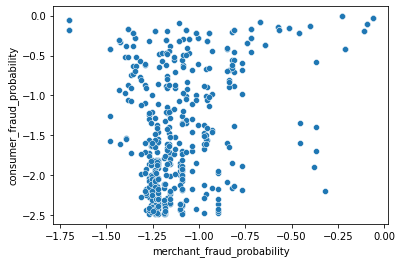

In [52]:
sns.scatterplot(data=df, x='merchant_fraud_probability', y='consumer_fraud_probability')

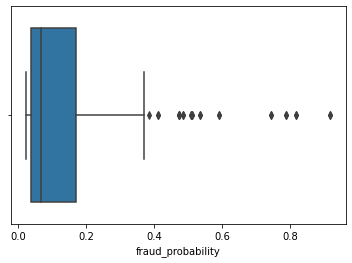

In [42]:
# df['fraud_probability'].plot(kind='hist')

sns.boxplot(data=df, x='fraud_probability')


In [45]:
IQR3 = df['fraud_probability'].describe()['75%']
frauds = df[df['fraud_probability'] > IQR3]

In [93]:
frauds[frauds['consumer_fraud_probability'] == 0.37503713553941315]

,merchant_abn,order_datetime,user_id,dollar_value,order_id,consumer_fraud_probability,merchant_fraud_probability,fraud_probability
219,14827550074,2021-11-26,19161,12951.227465,6d52d2a6-33c8-444f-94c6-823ba062b6d5,0.375037,0.464578,0.174234


<AxesSubplot:>

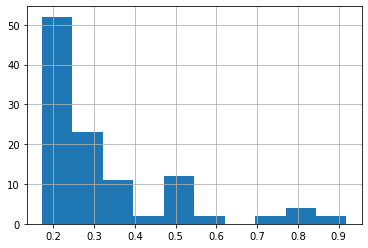

22/09/18 18:10:08 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 539293 ms exceeds timeout 120000 ms
22/09/18 18:10:08 WARN SparkContext: Killing executors is not supported by current scheduler.
22/09/18 18:41:12 WARN TransportChannelHandler: Exception in connection from /172.20.10.3:49305
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:276)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:233)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:223)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel

In [110]:
frauds['fraud_probability'].hist()

In [62]:
transactions

user_id,merchant_abn,dollar_value,order_id,order_datetime
130,60121698774,97.13218817833793,18b6b1e1-aa4f-400...,2022-08-20
529,29102388616,9.02021849647376,b93df7f4-82d3-465...,2022-08-20
11767,21439773999,81.92653136431059,31223568-f1b9-488...,2022-08-20
617,21793603759,50.550554205219164,4b63e362-9597-4b9...,2022-08-20
11826,69703285964,31.172003510803542,24dd8c15-a084-47e...,2022-08-20
11826,82065156333,12.039473294091733,1dd46aa5-eeb1-469...,2022-08-20
768,29102388616,2.860914150523363,e8583925-d298-465...,2022-08-20
11931,46804135891,12.709803893432923,307ccbbb-b8a9-451...,2022-08-20
950,32234779638,148.25800937044144,3c2a7c32-2055-40a...,2022-08-20
1035,63290521567,4.787462459753587,08a953a8-2a55-454...,2022-08-20


In [94]:
t = transactions.where(F.col('user_id') == 19161).toPandas()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dollar_value'>

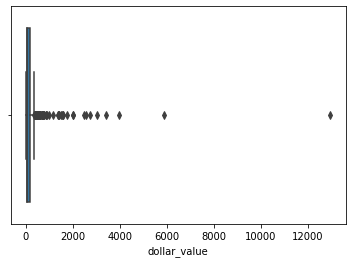

In [106]:
sns.boxplot(t['dollar_value'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dollar_value'>

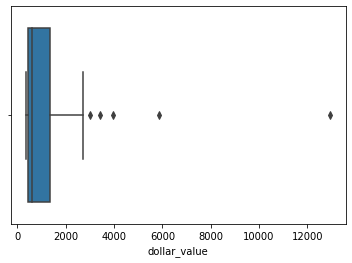

In [108]:
sns.boxplot(t[t['dollar_value'] > 350]['dollar_value'])